## 毒品資料為基礎建立隨機森林模型
1. balanced處理資料不平衡分佈
2. 超參數調教
3. 計算效能指標
4. ROC_AUC Curve
5. factor importance
6. confusion matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import imblearn

圖形顯示中文設定

In [2]:
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False

### 資料讀取

In [3]:
df = pd.read_csv("../data/traindrug.csv", encoding="utf8")

In [4]:
df.head() #觀察資料內容

,性別,教育,神智,年齡,每月採尿平均,實際保管長度,違規次數,獎勵次數,犯次,一年內次數,二年內次數,三年內次數,四年內次數,五年內次數,首犯年齡,再犯註記
0,1,4,3,3,2.333,1,0,0,5,0,0,0,3,4,0,0
1,1,3,2,3,0.000,1,0,0,2,0,0,0,1,0,0,0
2,1,3,2,3,1.000,3,0,2,4,0,0,0,0,0,1,0
3,1,3,0,4,1.714,1,0,0,5,0,0,0,0,0,1,1
4,1,3,0,3,0.871,4,0,1,2,0,0,0,0,0,0,0


In [5]:
df.columns #資料欄位名稱

Index(['性別', '教育', '神智', '年齡', '每月採尿平均', '實際保管長度', '違規次數', '獎勵次數', '犯次',
       '一年內次數', '二年內次數', '三年內次數', '四年內次數', '五年內次數', '首犯年齡', '再犯註記'],
      dtype='object')

In [6]:
df.shape #資料維度 16個欄位，65402筆資料

(65402, 16)

In [7]:
print(imblearn.__version__)

0.11.0


In [8]:
from collections import Counter

In [71]:
counter=Counter(y)

In [72]:
print(counter)

Counter({0: 53906, 1: 11496})


**找出再犯與非再犯資料分佈**

Text(0.5, 0, '再犯註記(1:再犯，0:非再犯)')

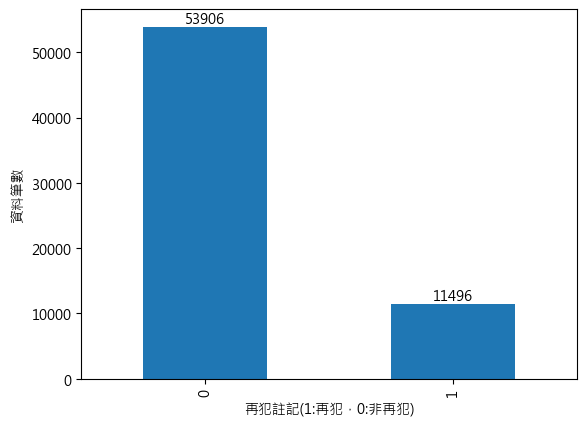

In [9]:
tgtn = df.groupby('再犯註記')
ax = tgtn.size().plot.bar()
ax.bar_label(ax.containers[0]) #顯示bar的資料數據 
ax.set_ylabel("資料筆數") #設定y軸標籤
ax.set_xlabel("再犯註記(1:再犯，0:非再犯)") #設定y軸標籤

### 建立訓練集與測試集(X, y)

In [10]:
X = df.drop(labels=['再犯註記'], axis=1).values
y = df['再犯註記'].values

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

### 超參數調教

In [13]:
# Import Random Forest model
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [14]:
rf.get_params() #get default params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### design of param grid

In [11]:
n_estimators = np.arange(100, 2000, step=200)
max_features = ["auto", "sqrt", "log2"]
max_depth = [2,4,6]
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

In [12]:
param_grid={
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [13]:
param_grid

{'n_estimators': array([ 100,  300,  500,  700,  900, 1100, 1300, 1500, 1700, 1900]),
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [2, 4, 6],
 'min_samples_split': array([2, 4, 6, 8]),
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'bootstrap': [True, False]}

### random search for hyperparameters

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestClassifier(class_weight='balanced', random_state=42)
rs_cv = RandomizedSearchCV(forest, param_grid, n_iter=100, cv=5, scoring="accuracy", n_jobs=-1)

In [16]:
import time
start = time.time()
_=rs_cv.fit(X, y)
end = time.time()
tt = end-start
print(tt/60)

19.47833631038666


In [18]:
rs_cv.best_score_

0.725956066026618

In [19]:
print(rs_cv.best_params_) # obtain params by random search

{'n_estimators': 700, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 6, 'bootstrap': True}


In [20]:
new_params = {
    "n_estimators": [600, 650, 700, 750, 800],
    "max_features": ['log2'],
    "max_depth": [4,5,6],
    "min_samples_split":[4,6, 8, 10],
    "min_samples_leaf": [3,4,5],
    "bootstrap": ["True"],
}

### fine turning hyperparameters by grid search

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
grid_cv = GridSearchCV(forest, new_params, cv=5, scoring="accuracy",n_jobs=-1)

In [23]:
import time
start = time.time()
_ = grid_cv.fit(train_X, train_y)
end = time.time()
tt = end-start
print(tt/60)

11.25304245154063


In [24]:
grid_cv.best_score_

0.7267637556234485

In [25]:
grid_cv.best_params_ # obtain params by grid search

{'bootstrap': 'True',
 'max_depth': 6,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 600}

In [24]:
# transfer best params to json format
import json
json_obj = json.dumps(grid_cv.best_params_, indent = 3) 
print(json_obj)

{
   "bootstrap": "True",
   "max_depth": 8,
   "max_features": "auto",
   "min_samples_leaf": 1,
   "min_samples_split": 4,
   "n_estimators": 750
}


In [25]:
# save best params to json file
with open("rf_config1.json", "w") as file:
    json.dump(grid_cv.best_params_, file)

In [26]:
fp = open("rf_config1.json", "r")
dd = json.load(fp)
fp.close()
print(dd)

{'bootstrap': 'True', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 750}


### 基於最佳模型組態之模型效能

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    bootstrap=True,
    max_depth=5,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=750
)

In [26]:
model = grid_cv.best_estimator_

### 計算效能指標

In [27]:

model.fit(train_X, train_y)
scores = cross_val_score(model, train_X, train_y, cv=5, scoring="accuracy")
t1 = model.score(train_X, train_y)
t2 = scores.mean()
t3 = model.score(test_X, test_y)
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)
t4 = f1_score(train_y, train_pred)
t5 = f1_score(test_y, test_pred)
t6 = precision_score(train_y, train_pred)
t7 = precision_score(test_y, test_pred)
train_proba = model.predict_proba(train_X)[:, 1]
test_proba = model.predict_proba(test_X)[:, 1]
t8 = roc_auc_score(train_y, train_proba)
t9 = roc_auc_score(test_y, test_proba)
names = ["total accuracy", "cv accuracy", "test accuracy", "train F1", "test F1", "train precision", "test precision", "train roc_auc", "test roc_auc"]
retlist=[t1, t2, t3, t4, t5, t6, t7, t8, t9]
retdf = pd.DataFrame(retlist, index=names)


In [28]:
print(retdf[0])

total accuracy     0.728350
cv accuracy        0.726764
test accuracy      0.721199
train F1           0.451172
test F1            0.441415
train precision    0.349005
test precision     0.343832
train roc_auc      0.769982
test roc_auc       0.756215
Name: 0, dtype: float64


### ROC_AUC curve

In [29]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

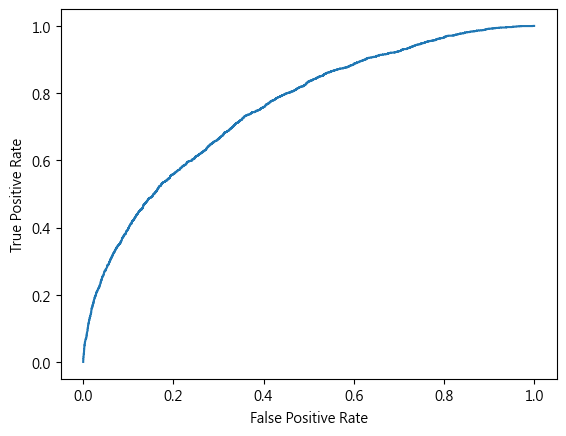

In [30]:
plot_roc_curve(test_y, test_proba)

### 影響因子重要性

In [31]:
fcolumns=['性別', '教育', '神智', '年齡', '每月採尿平均', '實際保管長度', '違規次數', '獎勵次數', '犯次',
       '一年內次數', '二年內次數', '三年內次數', '四年內次數', '五年內次數', '首犯年齡']

In [32]:
factImportance = pd.DataFrame({'feature':fcolumns,
                              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

In [33]:
print(factImportance)

   feature  importance
8       犯次    0.257080
5   實際保管長度    0.186646
2       神智    0.132529
1       教育    0.088996
4   每月採尿平均    0.079039
9    一年內次數    0.053509
7     獎勵次數    0.052514
10   二年內次數    0.034073
11   三年內次數    0.032293
14    首犯年齡    0.021019
12   四年內次數    0.020231
3       年齡    0.014021
13   五年內次數    0.013009
0       性別    0.011274
6     違規次數    0.003767


### 計算混淆矩陣confusion matrix

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, test_pred)

In [35]:
cm #confusion matrix

array([[7993, 2750],
       [ 897, 1441]], dtype=int64)

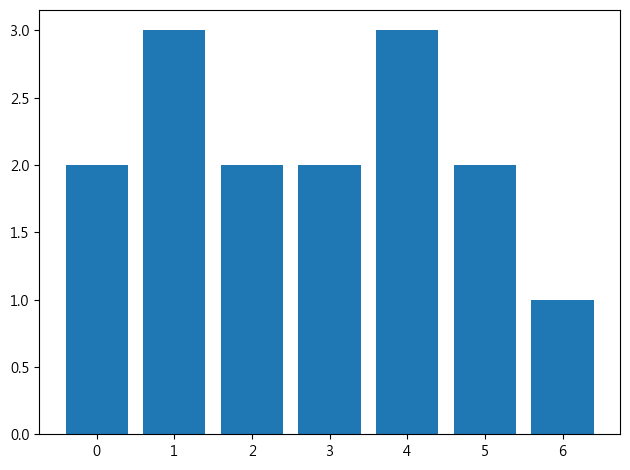

In [74]:
data = [0, 1, 2, 4, 1, 3, 0, 4, 1, 4, 3, 5, 6, 5, 2]

d = Counter(data)

plt.bar(d.keys(), d.values())

plt.show()